## Sources
[1] - Washington University St. Louis https://source.wustl.edu/2020/02/the-divide-between-us-urban-rural-political-differences-rooted-in-geography/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegressionCV

Based on feedback from the original assignment, despite their data quality issues, `hosp_yn`, `icu_yn` and `underlying_conditions_yn` have been reintroduced to the cleaned, extended features dataset.

In [4]:
df = pd.read_csv('covid19-cdc-sample-clean-extended_features.csv')

In [5]:
train, test = train_test_split(df, test_size=0.3, random_state=69)

There are no continuous features in the dataset

In [6]:
df[df.columns] = df[df.columns].astype('category')
df.dtypes

res_state                   category
res_county                  category
county_fips_code            category
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                    category
underlying_conditions_yn    category
year                        category
month                       category
season                      category
party                       category
rural                       category
dtype: object

<Figure size 1000x600 with 0 Axes>

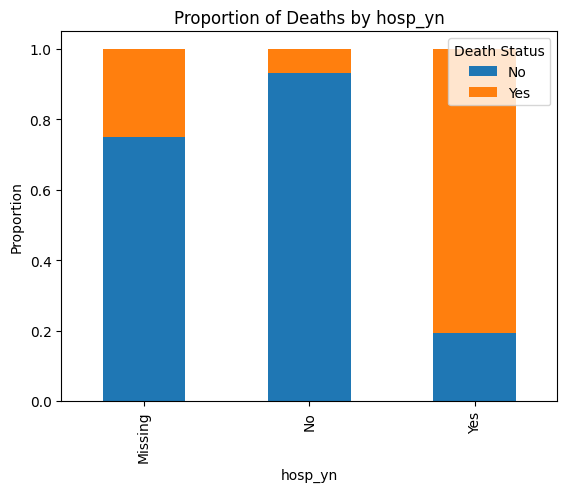

In [7]:
proportions = train.groupby('hosp_yn')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by hosp_yn")
plt.ylabel("Proportion")
plt.xlabel('hosp_yn')
plt.legend(title="Death Status")
plt.show()

There is clear predictive power to `hosp_yn`, and even the noise implicit in imputing a `Missing` category seems to tbe closer `No` than `Yes`

<Figure size 1000x600 with 0 Axes>

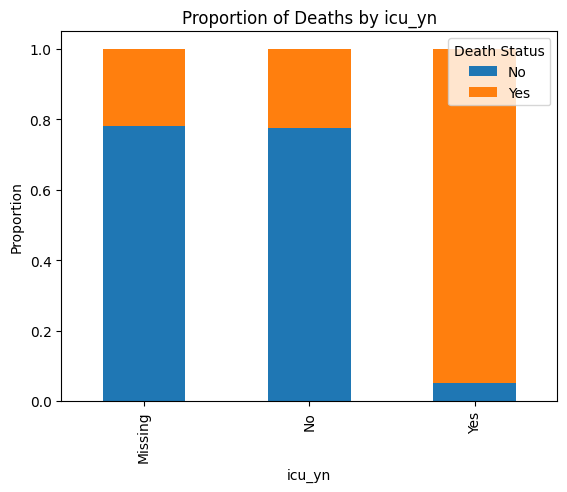

In [8]:
proportions = train.groupby('icu_yn')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by icu_yn")
plt.ylabel("Proportion")
plt.xlabel('icu_yn')
plt.legend(title="Death Status")
plt.show()

The pairwise interaction here confirms our suspicion about `Missing` being more likely `No` than `Yes` from the previous data quality report, the death rate for each are very similar. 

<Figure size 1000x600 with 0 Axes>

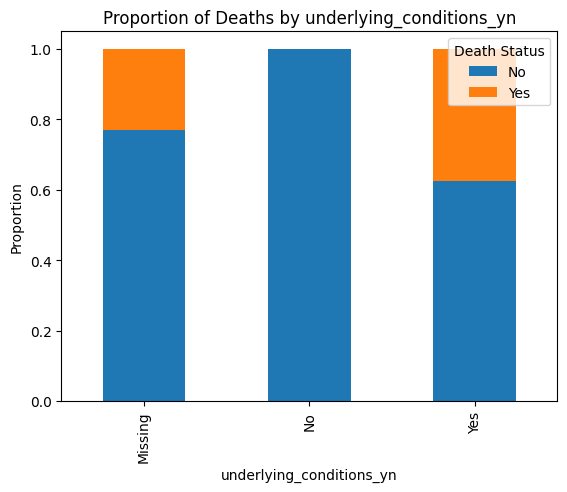

In [9]:
proportions = train.groupby('underlying_conditions_yn')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by underlying_conditions_yn")
plt.ylabel("Proportion")
plt.xlabel('underlying_conditions_yn')
plt.legend(title="Death Status")
plt.show()

In [10]:
df.underlying_conditions_yn.value_counts()

underlying_conditions_yn
Missing    25162
Yes         2318
No            49
Name: count, dtype: int64

This was somewhat surprising: my assumption would have been that `Missing` for `underlying_condidtions_yn` was more likely to have outcomes in line with `No`, not `Yes`. 

Considering the sample size issues with the `No` category, there may be a large number of true _No's_ contained within the `Missing` feature, therefore ``underlying_conditions_yn`` may not be as predictive as I would have imagined 

<Figure size 1000x600 with 0 Axes>

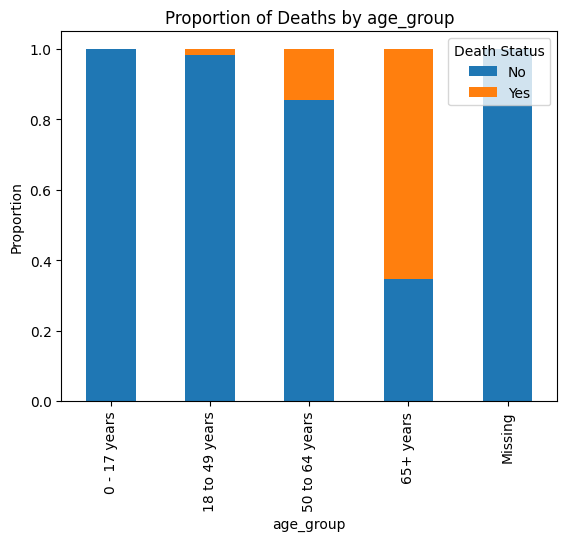

In [11]:
proportions = train.groupby('age_group')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by age_group")
plt.ylabel("Proportion")
plt.xlabel('age_group')
plt.legend(title="Death Status")
plt.show()

Based on the data, we can see that age is likely of predictive `death_yn`, with a large disparity between _65+ years_ and all other categories

<Figure size 1000x600 with 0 Axes>

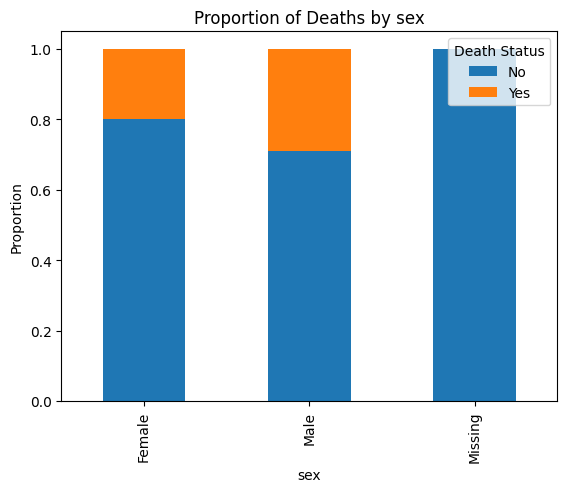

In [12]:
proportions = train.groupby('sex')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by sex")
plt.ylabel("Proportion")
plt.xlabel('sex')
plt.legend(title="Death Status")
plt.show()

In [13]:
proportions

sex      death_yn
Female   No          0.800575
         Yes         0.199425
Male     No          0.709224
         Yes         0.290776
Missing  No          1.000000
Name: proportion, dtype: float64

There is also a significant difference in outcomes based on sex: Males are almost 50% more likely to die than Females

<Figure size 1000x600 with 0 Axes>

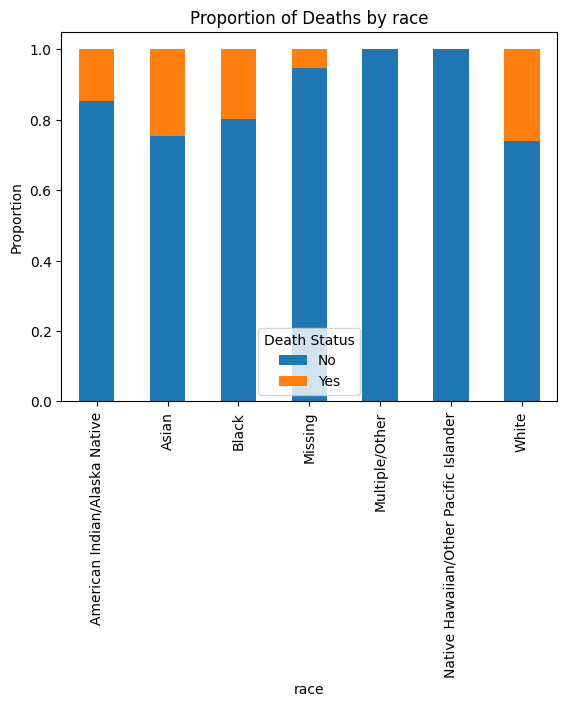

In [14]:
proportions = train.groupby('race')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by race")
plt.ylabel("Proportion")
plt.xlabel('race')
plt.legend(title="Death Status")
plt.show()

In [15]:
proportions

race                                    death_yn
American Indian/Alaska Native           No          0.852459
                                        Yes         0.147541
Asian                                   No          0.753346
                                        Yes         0.246654
Black                                   No          0.803845
                                        Yes         0.196155
Missing                                 No          0.945996
                                        Yes         0.054004
Multiple/Other                          No          1.000000
Native Hawaiian/Other Pacific Islander  No          1.000000
White                                   No          0.740208
                                        Yes         0.259792
Name: proportion, dtype: float64

In [16]:
df['race'].value_counts()

race
White                                     22064
Black                                      3600
Missing                                     787
Asian                                       766
Multiple/Other                              218
American Indian/Alaska Native                88
Native Hawaiian/Other Pacific Islander        6
Name: count, dtype: int64

There is a significant difference in outcomes between different races, however there is significant sample size issues with anything except `White` and `Black`

With respect to making predictions, it will be hard to justify including either any other features as they may disproportinately affect the predictions

For example, if an observation of `Native Hawaiian/Other Pacific Islander` passed as a parameter, it may see that 100% of this kind of observation lived, despite there being only 7 instances

<Figure size 1000x600 with 0 Axes>

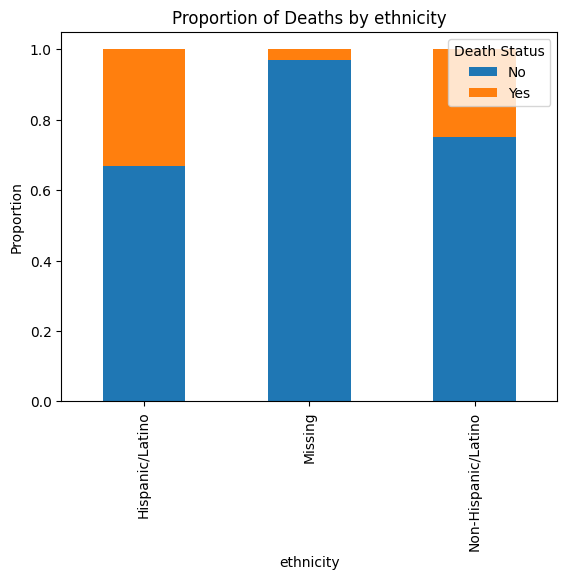

In [17]:
proportions = train.groupby('ethnicity')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by ethnicity")
plt.ylabel("Proportion")
plt.xlabel('ethnicity')
plt.legend(title="Death Status")
plt.show()

`Hispanic/Latino` has a higher death rate than `Non-Hispanic/Latino` and will likely prove valuable for predicting outcomes

In [18]:
df.ethnicity.value_counts()

ethnicity
Non-Hispanic/Latino    22385
Hispanic/Latino         3205
Missing                 1939
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

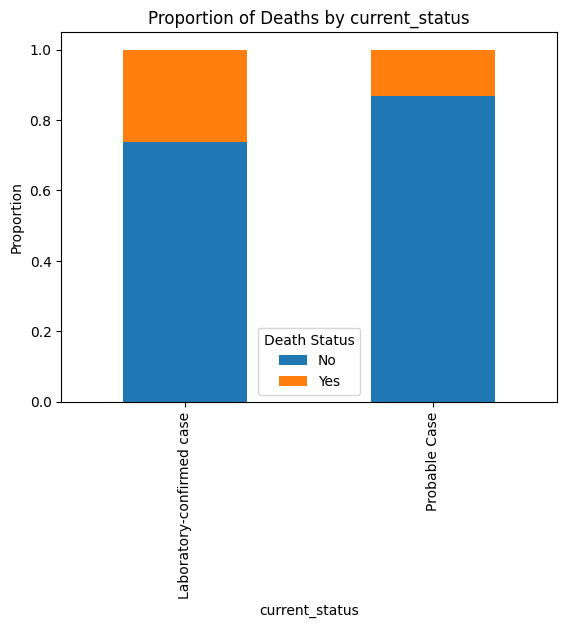

In [19]:
proportions = train.groupby('current_status')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by current_status")
plt.ylabel("Proportion")
plt.xlabel('current_status')
plt.legend(title="Death Status")
plt.show()

`Laboratory-confirmed case` shows significantly higher death risks, somewhat intuitvely as you would expect an observation with more severe symptoms/hospitalization status is more likely to receive a confirmed positive test than an observation with milder symptoms

<Figure size 1000x600 with 0 Axes>

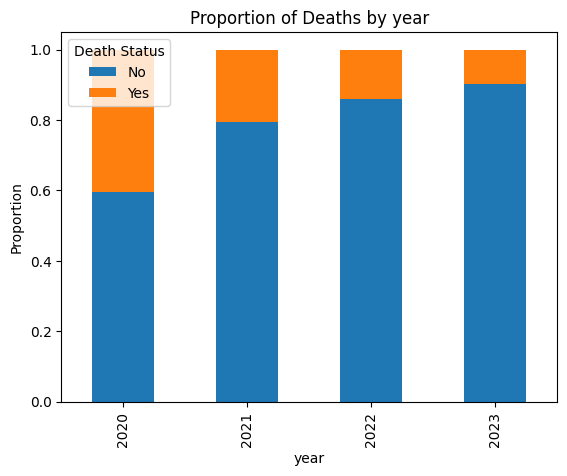

In [20]:
proportions = train.groupby('year')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by year")
plt.ylabel("Proportion")
plt.xlabel('year')
plt.legend(title="Death Status")
plt.show()

While there are differences in outcome based on the year, from a predictive point of view it may not be hugely useful

There are no observations from `2024` so we can't infer anything about death risk for an observation today

In [21]:
year_groups = df.groupby('year')

years = {}
for year, group in year_groups:
    years[year] = group

/tmp/ipykernel_370267/750475382.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_groups = df.groupby('year')


/tmp/ipykernel_370267/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

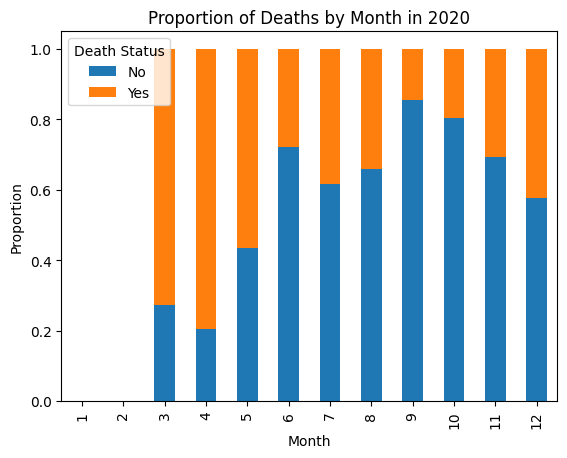

/tmp/ipykernel_370267/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

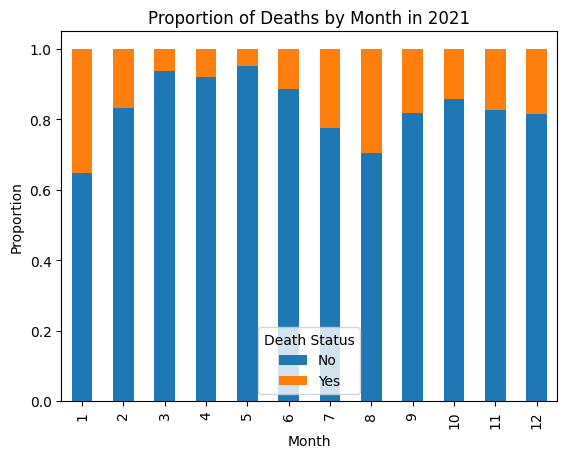

/tmp/ipykernel_370267/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

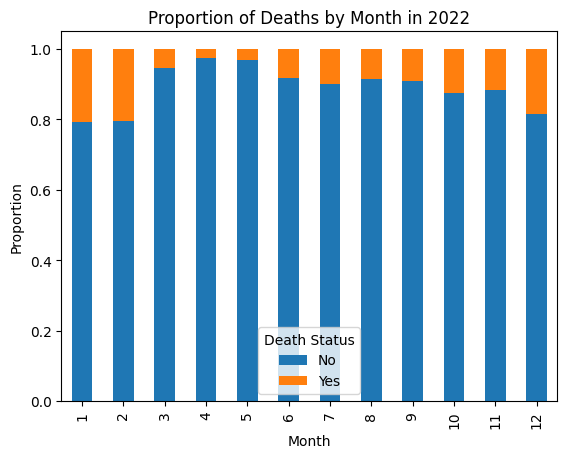

/tmp/ipykernel_370267/254371584.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)


<Figure size 1000x600 with 0 Axes>

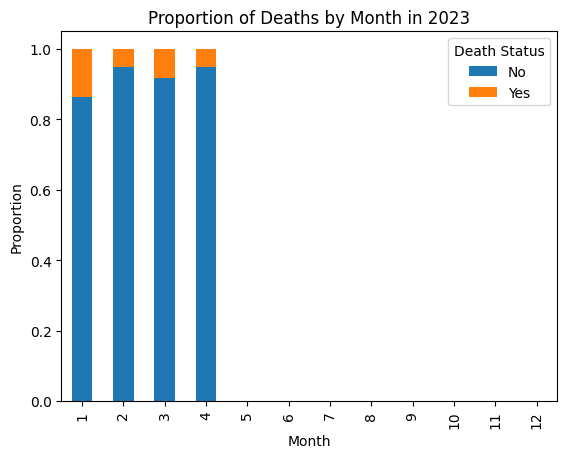

In [22]:
for year, df_year in years.items():
    proportions = df_year.groupby('month')['death_yn'].value_counts(normalize=True)
    
    # Step 3: Plot the Proportions
    plt.figure(figsize=(10, 6));
    proportions.unstack().plot(kind='bar', stacked=True)
    plt.title(f"Proportion of Deaths by Month in {year}")
    plt.ylabel("Proportion")
    plt.xlabel('Month')
    plt.legend(title="Death Status")
    plt.show()

The month of the year appears to be a useful predictor of `death_yn` however it must be considered with respect to `year`

We will be sure to be mindful of this in model construction

<Figure size 1000x600 with 0 Axes>

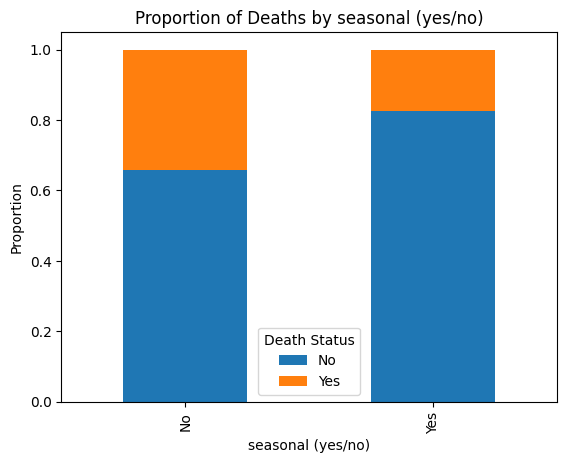

In [23]:
proportions = train.groupby('season')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by seasonal (yes/no)")
plt.ylabel("Proportion")
plt.xlabel('seasonal (yes/no)')
plt.legend(title="Death Status")
plt.show()

Now looking at some of the added features from assignment 1, a slight different (an unintuitive one at that) is present is whether or not a state experiences seasons

It's surprising insofar as I would have expected state that suffered harsher winters would have had worse outcomes on average

<Figure size 1000x600 with 0 Axes>

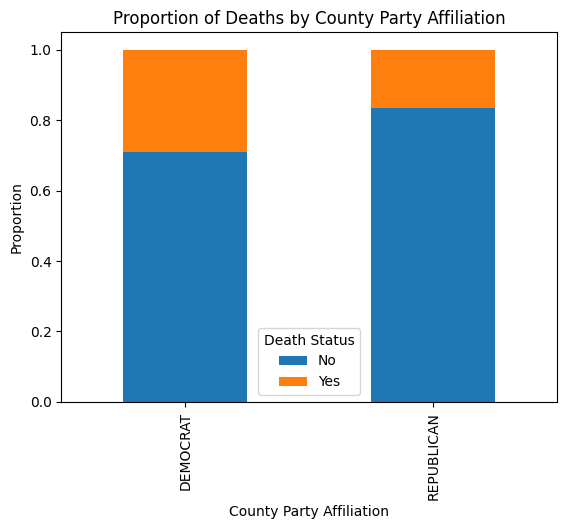

In [24]:
proportions = train.groupby('party')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by County Party Affiliation")
plt.ylabel("Proportion")
plt.xlabel('County Party Affiliation')
plt.legend(title="Death Status")
plt.show()

We once again see that `party` (County Party Affiliation from 2020 Presidential Election) how clear trends in outcomes, however I suspect it's related to our next added feature...

<Figure size 1000x600 with 0 Axes>

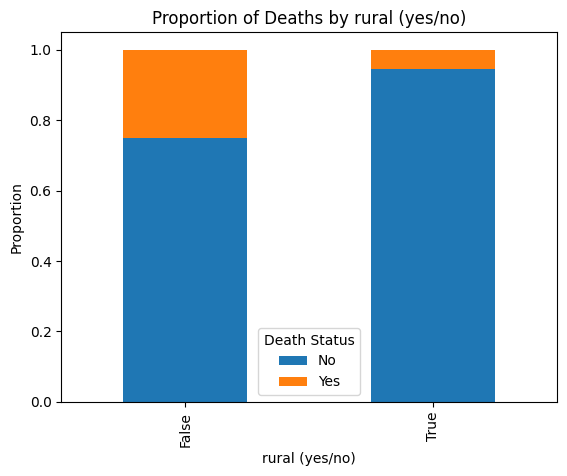

In [25]:
proportions = train.groupby('rural')['death_yn'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
proportions.unstack().plot(kind='bar', stacked=True)
plt.title(f"Proportion of Deaths by rural (yes/no)")
plt.ylabel("Proportion")
plt.xlabel('rural (yes/no)')
plt.legend(title="Death Status")
plt.show()

This was the most striking of the additionaly features we imputed: outcomes for those living in rural areas are far better than those living in greater population density areas

![alt text](2016_Nationwide_US_presidential_county_map_shaded_by_vote_share.svg_-1024x683.png "Title")

The above [1] is illustrative of the outcomes for `rural` and `party`: densely populated areas like the two coasts, Chicago in the mid-west, and the south of Texas vote overwhelmingly Democrat versus anywhere else in the country

It's worth exploring if there a covariance between these features before making any decisions on which should be included in a model

<Figure size 1200x800 with 0 Axes>

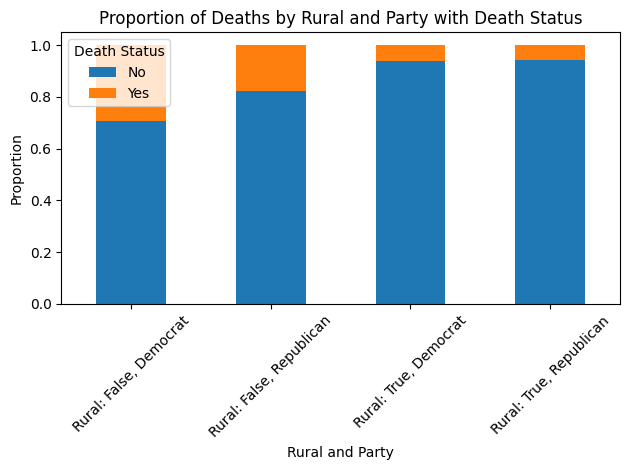

In [26]:
proportions_rural = train.groupby(['rural', 'party'])['death_yn'].value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(12, 8))
proportions_rural.plot(kind='bar', stacked=True)
plt.title('Proportion of Deaths by Rural and Party with Death Status')
plt.xlabel('Rural and Party')
plt.ylabel('Proportion')
plt.legend(title='Death Status')
plt.xticks(ticks=range(len(proportions_rural)), labels=[f'Rural: {rural}, {party.capitalize()}' for rural, party in proportions_rural.index], rotation=45)
plt.tight_layout()
plt.show()


I expected controlling for `rural` in this way would have given us a clearer insight, however both features appear to be indpendently useful predictors of `death_yn`.

## Feature selection

We will be dropping `race` before we build any models

`race` has sample size issues for any category other than `black` or `white`, and combining the other categories into `other` doesn't overcome this

There are large disapities in outcomes among these other categories also, so this would likely only add noise to the predictions

For this reason, and that the difference in outcome `death_yn` between `black` and `white` is modest: ~22% and ~27% respectively, I believe keeping this feature will negatively impact predictive accuracy

In [27]:
df = df.drop(columns=['race'])
df.head()

,res_state,res_county,county_fips_code,age_group,sex,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year,month,season,party,rural
0,TX,TARRANT,48439,65+ years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2020,11,No,DEMOCRAT,False
1,SC,HORRY,45051,65+ years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2022,1,No,REPUBLICAN,False
2,NY,QUEENS,36081,50 to 64 years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Missing,2020,3,Yes,DEMOCRAT,False
3,CT,NEW HAVEN,9009,65+ years,Female,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Yes,Missing,2020,11,Yes,DEMOCRAT,False
4,CT,FAIRFIELD,9001,65+ years,Male,Missing,Laboratory-confirmed case,Missing,Missing,Yes,Missing,2020,4,Yes,DEMOCRAT,False


Additionally, we will drop `res_state`, `res_county`, and `county_fips_code`: one-hot encoding an enormous number of categorical variables will make model inference quite difficult (and likely make them slow to train)

In imputing `season`, `party` and `rural` from these features, we have captured some of their predictive power, and as such they will be dropped

In [28]:
df = df.drop(columns=['res_state', 'res_county', 'county_fips_code'])
df.head()

,age_group,sex,ethnicity,current_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,year,month,season,party,rural
0,65+ years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2020,11,No,DEMOCRAT,False
1,65+ years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Yes,Missing,2022,1,No,REPUBLICAN,False
2,50 to 64 years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Yes,Missing,2020,3,Yes,DEMOCRAT,False
3,65+ years,Female,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Yes,Missing,2020,11,Yes,DEMOCRAT,False
4,65+ years,Male,Missing,Laboratory-confirmed case,Missing,Missing,Yes,Missing,2020,4,Yes,DEMOCRAT,False


In [29]:
df.isna().sum()

age_group                   0
sex                         0
ethnicity                   0
current_status              0
hosp_yn                     0
icu_yn                      0
death_yn                    0
underlying_conditions_yn    0
year                        0
month                       0
season                      0
party                       0
rural                       0
dtype: int64

## Feature Prepartion

All of our remaining features are categorical variables that need to be prepared before we can use them for prediction

Let's first seperate our target variable from the rest of our features `death_yn`

In [30]:
X = df.drop(columns=['death_yn'])
X

,age_group,sex,ethnicity,current_status,hosp_yn,icu_yn,underlying_conditions_yn,year,month,season,party,rural
0,65+ years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Missing,2020,11,No,DEMOCRAT,False
1,65+ years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Missing,2022,1,No,REPUBLICAN,False
2,50 to 64 years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Yes,Missing,2020,3,Yes,DEMOCRAT,False
3,65+ years,Female,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Missing,2020,11,Yes,DEMOCRAT,False
4,65+ years,Male,Missing,Laboratory-confirmed case,Missing,Missing,Missing,2020,4,Yes,DEMOCRAT,False
...,...,...,...,...,...,...,...,...,...,...,...,...
27524,18 to 49 years,Male,Missing,Probable Case,No,Missing,Missing,2022,5,Yes,REPUBLICAN,False
27525,0 - 17 years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Missing,2021,12,No,DEMOCRAT,False
27526,65+ years,Male,Non-Hispanic/Latino,Laboratory-confirmed case,No,Missing,Missing,2023,1,No,DEMOCRAT,False
27527,50 to 64 years,Female,Non-Hispanic/Latino,Laboratory-confirmed case,Yes,Missing,Missing,2020,12,No,DEMOCRAT,False


We will encoded `death_yn` to be either a 0 or a 1, no or yes, as our linear regression at least will expect a continuous target variable

In [31]:
y = df.death_yn.map({'Yes': 1, 'No': 0})
y

0        1
1        1
2        1
3        1
4        1
        ..
27524    0
27525    0
27526    0
27527    0
27528    0
Name: death_yn, Length: 27529, dtype: category
Categories (2, int64): [0, 1]

I'm content with one-hot encoding as I believe it supports useful inference and avoid the risk of arbitrarily ordering certain categories (even if that _may_ be valid for certain categories, i.e. `age_group` and `month`)

We have the option to drop the first column of each of categorical variables however I believe this negatively impacts the inference value of our data

While in the case of `sex`, we can intuitively understand what our reference column is, it may not be so obvious for `age_group` or `current_status` for example

Let's define a pre-processor to work with of our pipeline

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), X.columns), # can declare all X columns as all variables are categorical
    ],
    remainder='passthrough'
)

### Witholding a test set

To prevent the model overfiting to the training data, we will withhold a test set to validate our results

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

### A note on model "accuracy"

A key consideration for a classification test is balance: in this case we have significantly more `death_yn == no` than `yes`

In [34]:
y_test.value_counts()

death_yn
0    6306
1    1953
Name: count, dtype: int64

In [35]:
max(y_test.value_counts()) / len(y_test)

0.7635306937885943

This is important to note, as our `accuracy` scores will have to be taken with a grain of salt:

A model that always predicted `no` would have an accuracy of **~75%** and as such that should be our baseline for `accuracy` in investigating if we have a useful model

With this in mind `recall` and `precision`, (and relatedly `f1`) scores should be used to evaluate the models considering the unbalanced nature of the classification taks

## Linear Regression

In [36]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [37]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  Index(['age_group', 'sex', 'ethnicity', 'current_status', 'hosp_yn', 'icu_yn',
       'underlying_conditions_yn', 'year', 'month', 'season', 'party',
       'rural'],
      dtype='object'))])),
                ('model', LinearRegression())])

### Linear Regression Coefficients
As discussed earlier, I chose not to drop the reference columns as they are useful for inference: we need not wonder what the refernce column was as they are all below

In [38]:
coefficients = lr_pipeline.named_steps['model'].coef_
onehot_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=X.columns)
df_lr_coef = pd.DataFrame({'feature': onehot_columns, 'coefficients': coefficients})
df_lr_coef.sort_values(by='coefficients', ascending=False)

,feature,coefficients
3,age_group_65+ years,0.346690
15,hosp_yn_Yes,0.220835
22,year_2020,0.115996
18,icu_yn_Yes,0.108421
6,sex_Male,0.096260
5,sex_Female,0.068799
29,month_4,0.066615
26,month_1,0.060741
20,underlying_conditions_yn_No,0.056469
38,season_No,0.042243


#### Notable Coefficients
- `age_group_65+` as expected is a powerful predictor of `death_yn`, and is highly influential in an observation being `yes` for the value <br></br>
- `hosp_yn`, `icu_yn` and `underlying_conditions_yn` are also strong predictors, of death `Yes` and `No` if they are positive or negative respectively<br></br>
- `year_2020` is also highly predictve, as discussed in the last assignment, vaccination rates and general understanding of the virus were low at this time<br></br>
- `month_1` (January) is also somewhat predictive (of `death_yn == yes`), presumably because of colder mean temperatures and more time spent indoors<br></br>
- `month_4` has a relatively high coefficient (more likely to die) and can be attributed to the genesis of the virus being around that time in 2020<br></br>
- `age_group_0-17` and `age_group_18 to 49` are negative predictors (less likely to die), intuitvely enough as younger people were expected to have better outcomes<br></br>
- `year_2023` is also a negative predictor, presumably because vaccination rates steadily grew, and people caught the virus, survived and developed immunity

In [39]:
first_ten = lr_pipeline.predict(X_test[:10])
print(["No" if each < 0.5 else "Yes" for each in first_ten])

['No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes']


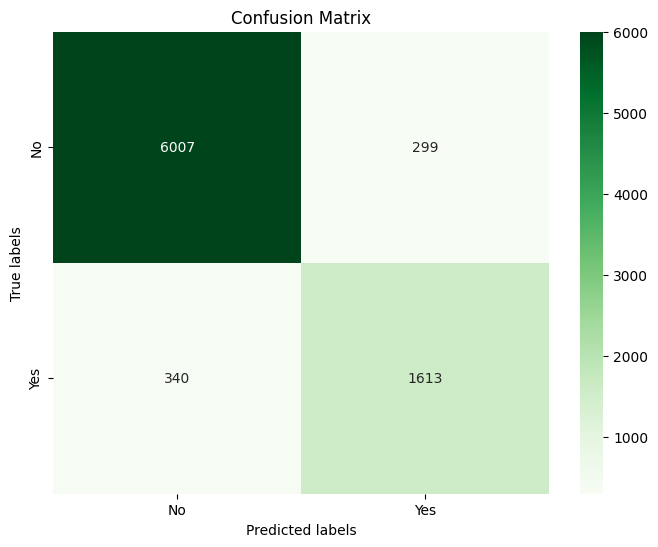

In [40]:
lr_results = lr_pipeline.predict(X_test)
lr_predictions = [0 if result < 0.5 else 1 for result in lr_results]

conf_matrix = confusion_matrix(y_test, lr_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
def print_scores(y_test, predictions):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    return [accuracy, precision, recall, f1]

In [42]:
print_scores(y_test, lr_predictions);

Accuracy: 0.9226298583363604
Precision: 0.8436192468619247
Recall: 0.8259088581669227
F1 Score: 0.8346701164294955


Compared to a baseline of **~50%**, the linear regression has quite impressive `accuracy` at around **~92%**

``Precision`` measures the model's ability to correctly predict positive observations, **true positives : true positives + false positives**

Comparing this to accuracy, it would mean the model is slightly better at detecting true negatives than true positives

`Recall` measure's the ability of the model to detect _all_ positive observations, **true positives : true positive + false negatives**

With respect to the problem domain, infectious diseases, it may be a priority to detect the highest rate of positive obvservations (`death_yn`) as possible, so care can be provided appropriately

`F1 score` represents a balance of `precision` and ``recall``, and as we mentioned already, the model appears to be better at predicting true negatives than true positives, although this could be due to the unbalanced natureo of the dataset

We will also cross validate the model on the entire dataset

In [43]:
def cross_val_scores(pipeline, X, y):
    scores = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : []
        }
    
    for n in range(1, 6):
        X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.3, random_state=n)
        pipeline.fit(X_train_cv, y_train_cv)
        pipeline_results = pipeline.predict(X_test_cv)

        # next step is redundant for logistic regression and random forest
        # but let's me use the same function for all the models
        pipeline_predictions = [0 if result < 0.5 else 1 for result in pipeline_results]
        print(f"CV Scores Fold {n}")
        for type, score in zip(scores, print_scores(y_test_cv, pipeline_predictions)):
            scores[type].append(score)
        print()
    return scores

In [44]:
lr_scores = cross_val_scores(lr_pipeline, X, y);

CV Scores Fold 1
Accuracy: 0.9242038987770916
Precision: 0.8512642538423401
Recall: 0.8404307391091532
F1 Score: 0.8458128078817734

CV Scores Fold 2
Accuracy: 0.9197239375227025
Precision: 0.8450704225352113
Recall: 0.8157099697885196
F1 Score: 0.830130668716372

CV Scores Fold 3
Accuracy: 0.9168180167090447
Precision: 0.8381294964028777
Recall: 0.8142785821268098
F1 Score: 0.8260319068118511

CV Scores Fold 4
Accuracy: 0.9199660975905073
Precision: 0.8463870641738251
Recall: 0.8243110236220472
F1 Score: 0.8352031912241337

CV Scores Fold 5
Accuracy: 0.9208136578278242
Precision: 0.8395939086294416
Recall: 0.8303212851405622
F1 Score: 0.8349318525996972



Cross validation with a number of random state _test/train splits_ gives us a more robust set of results are quite similar to our first split

## Logistic Regression

We will define the logistic regression pipeline using the same preprocessor as with the linear regression

In [45]:
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [46]:
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  Index(['age_group', 'sex', 'ethnicity', 'current_status', 'hosp_yn', 'icu_yn',
       'underlying_conditions_yn', 'year', 'month', 'season', 'party',
       'rural'],
      dtype='object'))])),
                ('model', LogisticRegression())])

In [47]:
coefficients = log_reg_pipeline.named_steps['model'].coef_.reshape(-1)
onehot_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=X.columns)
df_log_reg_coef = pd.DataFrame({'feature': onehot_columns, 'coefficients': coefficients})
df_log_reg_coef.sort_values(by='coefficients', ascending=False)

,feature,coefficients
3,age_group_65+ years,3.370828
22,year_2020,1.318753
15,hosp_yn_Yes,1.154241
18,icu_yn_Yes,1.044227
29,month_4,0.950659
26,month_1,0.814327
8,ethnicity_Hispanic/Latino,0.677403
2,age_group_50 to 64 years,0.630439
23,year_2021,0.380780
38,season_No,0.289200


#### Notable Coefficients
There are no new coefficients of note relative to the linear regression with a an exception:<br></br>
- `ethnicity_Missing` seems to be having a greater impact, reducing the risk of dying due to covid-19 in the logistic regression model<br></br>

The differences in which these learned weights are different because the loss function is different: linear regression is attempting to minimise mean squared error loss and logistic regression is attempting to minimise logistic loss

In [48]:
first_ten = log_reg_pipeline.predict(X_test[:10])
print(["No" if each < 0.5 else "Yes" for each in first_ten])

['No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes']


In [49]:
log_reg_results = log_reg_pipeline.predict(X_test)

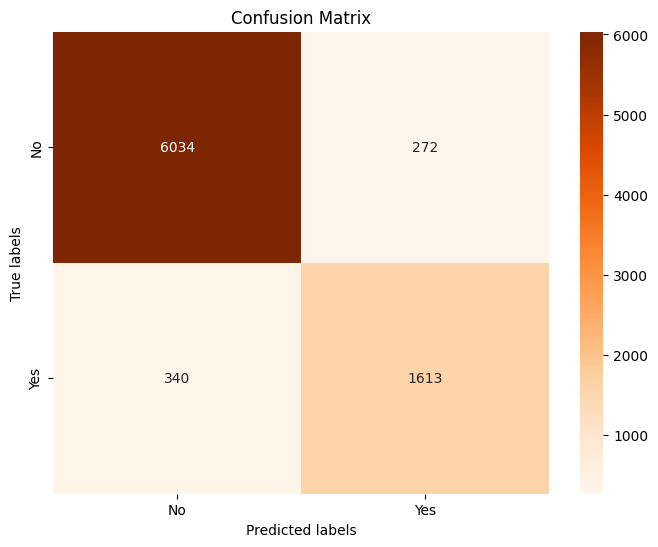

In [50]:
log_reg_predictions = [0 if result < 0.5 else 1 for result in log_reg_results]

conf_matrix = confusion_matrix(y_test, log_reg_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print("Logistic Regression Scores")
print_scores(y_test, log_reg_predictions);

Logistic Regression Scores
Accuracy: 0.9258990192517254
Precision: 0.8557029177718833
Recall: 0.8259088581669227
F1 Score: 0.8405419489317353


In [52]:
log_reg_scores = cross_val_scores(log_reg_pipeline, X, y);

CV Scores Fold 1
Accuracy: 0.9280784598619688
Precision: 0.8613466334164589
Recall: 0.8453255017131669
F1 Score: 0.8532608695652174

CV Scores Fold 2
Accuracy: 0.9233563385397748
Precision: 0.8521603331598125
Recall: 0.824269889224572
F1 Score: 0.8379831072434093

CV Scores Fold 3
Accuracy: 0.9212979779634338
Precision: 0.8418393127842345
Recall: 0.8317523714428358
F1 Score: 0.8367654445002511

CV Scores Fold 4
Accuracy: 0.9240828187431892
Precision: 0.8535480624056366
Recall: 0.8346456692913385
F1 Score: 0.8439910425478975

CV Scores Fold 5
Accuracy: 0.9226298583363604
Precision: 0.8453292496171516
Recall: 0.8313253012048193
F1 Score: 0.8382687927107062



In [53]:
pd.DataFrame(lr_scores).mean()

accuracy     0.920305
precision    0.844089
recall       0.825010
f1           0.834422
dtype: float64

In [54]:
pd.DataFrame(log_reg_scores).mean()

accuracy     0.923889
precision    0.850845
recall       0.833464
f1           0.842054
dtype: float64

The results of the logistic regression are very similar to that of the linear regression, only marginally improved

## Random Forest

As before, we will use the same preprocessor for a Random Forest Classifier

We will keep `oob_scores=True` to compare with it's performance on the test data

In [55]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(oob_score=True, random_state=22))
])

In [56]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  Index(['age_group', 'sex', 'ethnicity', 'current_status', 'hosp_yn', 'icu_yn',
       'underlying_conditions_yn', 'year', 'month', 'season', 'party',
       'rural'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(oob_score=True, random_state=22))])

## Notable Features

In [57]:
feature_importance = rf_pipeline.named_steps['model'].feature_importances_
onehot_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(input_features=X.columns)
df_feature_importance = pd.DataFrame({'feature': onehot_columns, 'feature_importance': feature_importance})
df_feature_importance.sort_values(by='feature_importance', ascending=False)

,feature,feature_importance
3,age_group_65+ years,0.198741
15,hosp_yn_Yes,0.153819
14,hosp_yn_No,0.122828
1,age_group_18 to 49 years,0.083636
22,year_2020,0.033298
13,hosp_yn_Missing,0.031893
0,age_group_0 - 17 years,0.029791
39,season_Yes,0.028996
18,icu_yn_Yes,0.028010
38,season_No,0.022478


Random forests are more difficult to interpret than linear models, and as such we don't have discrete coefficients for each feature.

However, `feature_importance` is a useful metric to identify which variables have the influence across the decision trees of the model

The higher the feature importance, the better the feature is at reducing the impurity of each split in the decision tree, in other words, the feature that best seperates different classes of outcomes, in this case `death_yn`

These rankings of `feature_importance` are broadly similar to the most impactful coefficients that we discovered building the linear models

With the notable exception of `underlying_conditions_yn`, which was given more weight by both the logistic and linear regressions

Additionally, the important features are intuitive with out understanding of infectious diseases: outcomes are worse for older people, better for younger, dependent on hospitalization or ICU treatment, and worse the less prepared (vaccinated etc.) people are, i.e. `year_2020`

In [58]:
first_ten = rf_pipeline.predict(X_test[:10])
print(["No" if each < 0.5 else "Yes" for each in first_ten])

['No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes']


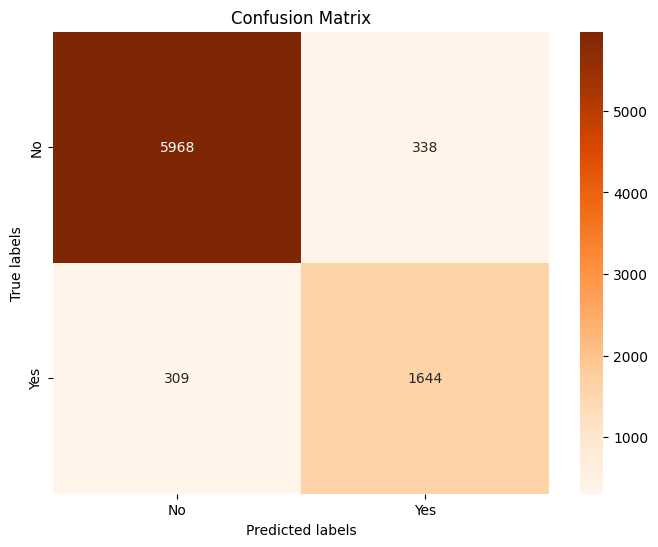

In [59]:
rf_results = rf_pipeline.predict(X_test)
rf_predictions = [0 if result < 0.5 else 1 for result in rf_results]

conf_matrix = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [60]:
print("Random Forest Classifier Scores")
print_scores(y_test, rf_predictions);

Random Forest Classifier Scores
Accuracy: 0.921661218065141
Precision: 0.829465186680121
Recall: 0.8417818740399385
F1 Score: 0.8355781448538755


At first glance these scores seem broadly in line with the linear models

In [61]:
rf_scores = cross_val_scores(rf_pipeline, X, y);

CV Scores Fold 1
Accuracy: 0.9229930984380675
Precision: 0.8410082404265633
Recall: 0.8492413117963779
F1 Score: 0.8451047247929859

CV Scores Fold 2
Accuracy: 0.9252936190822133
Precision: 0.8458817584638706
Recall: 0.8429003021148036
F1 Score: 0.8443883984867592

CV Scores Fold 3
Accuracy: 0.9206925777939218
Precision: 0.8281402142161636
Recall: 0.8492261607588617
F1 Score: 0.8385506531920138

CV Scores Fold 4
Accuracy: 0.9206925777939218
Precision: 0.8347107438016529
Recall: 0.84498031496063
F1 Score: 0.8398141354854488

CV Scores Fold 5
Accuracy: 0.9204504177261169
Precision: 0.8241864983001457
Recall: 0.8519076305220884
F1 Score: 0.8378178227598124



In [62]:
rf_pipeline.named_steps['model'].oob_score_

0.9205500778412039

Cross validation reveal results consistent with the Out-Of-Bag score, an R<sup>2</sup> Score (`accuracy`) of **~92%** (it's performance on the data not included in the sample data the random forest trains on)

## The "Best" Model

With repect to the problem statement **"...using the data collected by CDC to build a data analytics solution for death risk prediction."**, I believe that the most important score in this case is a model's `recall`

`recall` is the model's ability to capture all positive observations, in this case I believe the propensity of a model to produce false positives is less important than capturing the highest proportion of true positives

A false negative in this case would mean an observation with a high risk of death isn't captured and they may not receive appropriate treatment

In contrast with selecting, say `precision`, which weights false positives more highly, the consequences for incorrectly classifying a lower risk of death observation as higher risk of death are less serious

In [63]:
df_lr_scores = pd.DataFrame(lr_scores)
df_lr_scores

,accuracy,precision,recall,f1
0,0.924204,0.851264,0.840431,0.845813
1,0.919724,0.845070,0.815710,0.830131
2,0.916818,0.838129,0.814279,0.826032
3,0.919966,0.846387,0.824311,0.835203
4,0.920814,0.839594,0.830321,0.834932


In [64]:
df_log_reg_scores = pd.DataFrame(log_reg_scores)
df_log_reg_scores

,accuracy,precision,recall,f1
0,0.928078,0.861347,0.845326,0.853261
1,0.923356,0.852160,0.824270,0.837983
2,0.921298,0.841839,0.831752,0.836765
3,0.924083,0.853548,0.834646,0.843991
4,0.922630,0.845329,0.831325,0.838269


In [65]:
df_rf_scores = pd.DataFrame(rf_scores)
df_rf_scores

,accuracy,precision,recall,f1
0,0.922993,0.841008,0.849241,0.845105
1,0.925294,0.845882,0.842900,0.844388
2,0.920693,0.828140,0.849226,0.838551
3,0.920693,0.834711,0.844980,0.839814
4,0.920450,0.824186,0.851908,0.837818


In [66]:
print("Linear Regression\n", df_lr_scores.mean())
print("\nLogistic Regression\n", df_log_reg_scores.mean())
print("\nRandom Forest\n", df_rf_scores.mean())

Linear Regression
 accuracy     0.920305
precision    0.844089
recall       0.825010
f1           0.834422
dtype: float64

Logistic Regression
 accuracy     0.923889
precision    0.850845
recall       0.833464
f1           0.842054
dtype: float64

Random Forest
 accuracy     0.922024
precision    0.834785
recall       0.847651
f1           0.841135
dtype: float64


`Accuracy` scores for all the models are basically indentical, but the Random Forest has the best `Recall` score, again, the metric I believe is most appropriate on which to evaluate

We will see if we can make some improvements to each of these models

## Improvements

### Feature Selection and the Bias-Variance Trade-Off

With an eye to improve the model's performance on unseen data, I want to ensure it isn't overfitting to the training data

When calling `pipeline_du_jour.fit(X_train, y_train)`, it is attempting to minimise the error based the training data

However, some of the features included in ``X_train`` may only be helping the model minimise error with respect to the training data, _not_ unseen data

In other words, it's simply memorising the noise in the training data that doesn't generalise well to unseen data, which can result in high-variance in results on test sets

In an effort to reduce this variance, it would necessarily involve increasing the bias of the model, i.e. how reductionist we are about the nature of the problem and making decisions what variables are _really_ moving the needly on predictions

As we can see from the coefficients seen above, many of them are close to 0, i.e. not very predictive and likely just overfitting to the training data

An Elastic Net provides some regularisation and feature selection to our features

It adds a penalty to the coefficents in proportion to the magnitude of all coefficients so they become zero and effectively selects the features to proceded with

Our models will be simpler, but should be able to generalise better as we stop learning from noisy coefficients

In [67]:
el_net_feature_select = Pipeline([
    ('preprocessor', preprocessor), # standard preprocessor from earlier
    ('feature_selection', SelectFromModel(ElasticNetCV())), # feature selection
    # ('feature_selection', SelectFromModel(RidgeCV())), # feature selection
    ('model', ElasticNetCV())
])

In [68]:
el_net_feature_select.fit(X_train, y_train)

# Get the feature selector
selector = el_net_feature_select.named_steps['feature_selection']
feature_names = el_net_feature_select.named_steps['preprocessor'].get_feature_names_out()

selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]
print("Selected features:", len(selected_features), "Original features:", len(feature_names))
[print(feature) for feature in selected_features];

Selected features: 13 Original features: 44
onehot__age_group_0 - 17 years
onehot__age_group_18 to 49 years
onehot__age_group_65+ years
onehot__hosp_yn_No
onehot__hosp_yn_Yes
onehot__icu_yn_Yes
onehot__year_2020
onehot__year_2021
onehot__year_2023
onehot__month_1
onehot__month_4
onehot__season_No
onehot__party_DEMOCRAT


The selected features are quite interesting: 
- as previously suspected `underlying_conditions_yn` didn't make the cut: there was likely too much noise in the imputed `Missing` category
- `hosp_yn` and `icu_yn`, the other features reintroduced based on feedback are both retained
- pleasingly enough, many imputed features seem to useful in predicting outcomes: `year` and `month` with respect to some categories was retained, as well as `season` and `party`
- Party, if you'll remember, was linked to rural/urban earlier, and I wonder if some of `rural_yn` has been captured in `party`

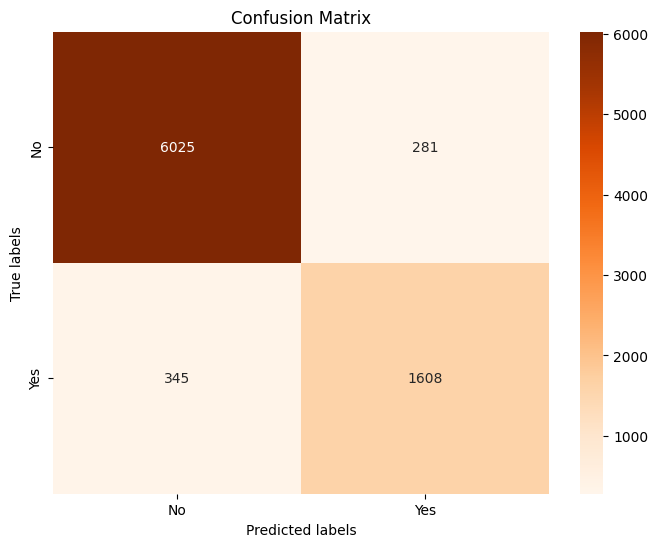

In [69]:
el_net_results = el_net_feature_select.predict(X_test)
el_net_predictions = [0 if result < 0.5 else 1 for result in el_net_results]

conf_matrix = confusion_matrix(y_test, el_net_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [70]:
print_scores(y_test, el_net_predictions);

Accuracy: 0.9242038987770916
Precision: 0.8512440444679725
Recall: 0.8233486943164362
F1 Score: 0.8370640291514836


In [71]:
el_net_feat_select_scores = cross_val_scores(el_net_feature_select, X, y);

CV Scores Fold 1
Accuracy: 0.9229930984380675
Precision: 0.8558421851289834
Recall: 0.8281938325991189
F1 Score: 0.8417910447761194

CV Scores Fold 2
Accuracy: 0.9211768979295314
Precision: 0.8541114058355438
Recall: 0.81067472306143
F1 Score: 0.8318264014466547

CV Scores Fold 3
Accuracy: 0.9174234168785568
Precision: 0.844548774126239
Recall: 0.8082875686470294
F1 Score: 0.8260204081632653

CV Scores Fold 4
Accuracy: 0.9193606974209952
Precision: 0.8527892561983471
Recall: 0.8125
F1 Score: 0.8321572580645161

CV Scores Fold 5
Accuracy: 0.9200871776244097
Precision: 0.8483263598326359
Recall: 0.8142570281124498
F1 Score: 0.8309426229508197



In [72]:
df_el_net_feat_select_scores = pd.DataFrame(el_net_feat_select_scores)

In [73]:
df_el_net_feat_select_scores.mean()

accuracy     0.920208
precision    0.851124
recall       0.814783
f1           0.832548
dtype: float64

In [74]:
df_lr_scores.mean()

accuracy     0.920305
precision    0.844089
recall       0.825010
f1           0.834422
dtype: float64

i'm happy to have reduced the number of features down from **44** to **14**, without significantly reducing the `recall` score from the linear regression model

Which to reiterate, I think it's the most valuable metric given the problem domain and the consequences of false negatives

### Logistic Regression

We will perform some features selection on the Logistic Regression as well

In [75]:
log_reg_feature_select = Pipeline([
    ('preprocessor', preprocessor),  # standard preprocessor from earlier
    ('feature_selection', SelectFromModel(LogisticRegressionCV())),  # feature selection
    ('model', LogisticRegressionCV())
])

In [76]:
log_reg_feature_select.fit(X_train, y_train)

# Get the feature selector
selector = log_reg_feature_select.named_steps['feature_selection']
feature_names = log_reg_feature_select.named_steps['preprocessor'].get_feature_names_out()

selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]
print("Selected features:", len(selected_features), "Original features:", len(feature_names))
[print(feature) for feature in selected_features];

Selected features: 17 Original features: 44
onehot__age_group_0 - 17 years
onehot__age_group_18 to 49 years
onehot__age_group_50 to 64 years
onehot__age_group_65+ years
onehot__ethnicity_Hispanic/Latino
onehot__ethnicity_Missing
onehot__hosp_yn_No
onehot__hosp_yn_Yes
onehot__icu_yn_No
onehot__icu_yn_Yes
onehot__year_2020
onehot__year_2023
onehot__month_1
onehot__month_4
onehot__month_6
onehot__season_Yes
onehot__rural_1.0


`LogisticRegressionCV` has chosen a similar number of features as the Elastic Net, but different in some respects: it more highly weights `ethnicity`

I'm curious to see how it performs in comparison

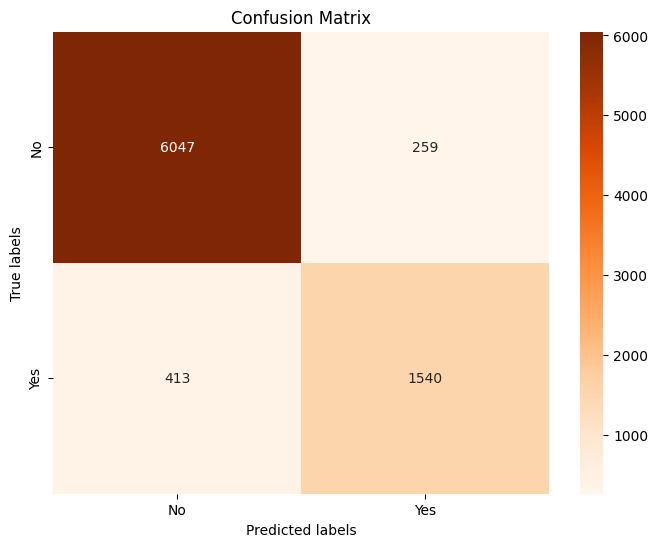

In [77]:
log_reg_feature_select_results = log_reg_feature_select.predict(X_test)
log_reg_feature_select_predictions = [0 if result < 0.5 else 1 for result in log_reg_feature_select_results]

conf_matrix = confusion_matrix(y_test, log_reg_feature_select_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [78]:
log_reg_feat_select_scores = cross_val_scores(log_reg_feature_select, X, y);

CV Scores Fold 1
Accuracy: 0.9200871776244097
Precision: 0.859968766267569
Recall: 0.8086147821830642
F1 Score: 0.8335015136226034

CV Scores Fold 2
Accuracy: 0.9180288170480688
Precision: 0.8562874251497006
Recall: 0.7920443101711984
F1 Score: 0.8229139419304211

CV Scores Fold 3
Accuracy: 0.9160915365056302
Precision: 0.8418580375782881
Recall: 0.8052920619071393
F1 Score: 0.8231691758101557

CV Scores Fold 4
Accuracy: 0.9148807361666061
Precision: 0.847360167276529
Recall: 0.797736220472441
F1 Score: 0.8217997465145754

CV Scores Fold 5
Accuracy: 0.9176655769463615
Precision: 0.8427377220480669
Recall: 0.8097389558232931
F1 Score: 0.8259088581669227



In [79]:
df_log_reg_feat_select_scores = pd.DataFrame(log_reg_feat_select_scores)

In [80]:
df_log_reg_feat_select_scores.mean()

accuracy     0.917351
precision    0.849642
recall       0.802685
f1           0.825459
dtype: float64

In [81]:
df_log_reg_scores.mean()

accuracy     0.923889
precision    0.850845
recall       0.833464
f1           0.842054
dtype: float64

While we were able to reduce the number of features down to the **15** from **44**, `recall` has suffered somewhat and it would be difficult to justify using this over the feature-selected linear regression

### Random Forest

We will try some feature selection for the Random Forest as with the linear models

In [82]:
rf_feature_select = Pipeline([
    ('preprocessor', preprocessor),  # standard preprocessor from earlier
    ('feature_selection', SelectFromModel(RandomForestClassifier())),  # feature selection
    ('model', RandomForestClassifier(oob_score=True, random_state=22))
])

In [83]:
rf_feature_select.fit(X_train, y_train)

# Get the feature selector
selector = rf_feature_select.named_steps['feature_selection']
feature_names = rf_feature_select.named_steps['preprocessor'].get_feature_names_out()

selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]
print("Selected features:", len(selected_features), "Original features:", len(feature_names))
[print(feature) for feature in selected_features];

Selected features: 10 Original features: 44
onehot__age_group_0 - 17 years
onehot__age_group_18 to 49 years
onehot__age_group_50 to 64 years
onehot__age_group_65+ years
onehot__hosp_yn_Missing
onehot__hosp_yn_No
onehot__hosp_yn_Yes
onehot__icu_yn_Yes
onehot__year_2020
onehot__season_No


The Random Forest was far more selective in the features it considered important for prediction

Because of this we can have more faith in it's ability to perform reliably on unseen data

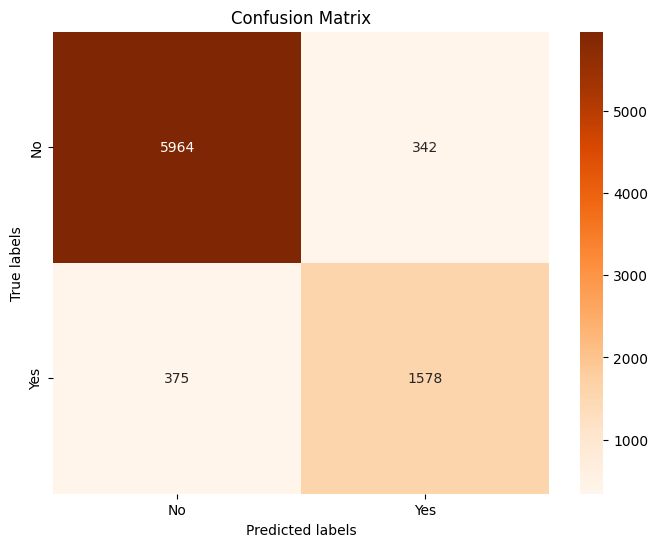

In [84]:
rf_feat_select_results = rf_feature_select.predict(X_test)
rf_feat_select_predictions = [0 if result < 0.5 else 1 for result in rf_feat_select_results]

conf_matrix = confusion_matrix(y_test, rf_feat_select_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [85]:
print_scores(y_test, rf_feat_select_predictions);

Accuracy: 0.9131856156919724
Precision: 0.821875
Recall: 0.8079877112135176
F1 Score: 0.814872192099148


In [86]:
rf_feat_select_scores = cross_val_scores(rf_feature_select, X, y);

CV Scores Fold 1
Accuracy: 0.91306453565807
Precision: 0.8324134470647265
Recall: 0.8120411160058737
F1 Score: 0.8221010901883052

CV Scores Fold 2
Accuracy: 0.91306453565807
Precision: 0.8244626407369499
Recall: 0.8111782477341389
F1 Score: 0.817766497461929

CV Scores Fold 3
Accuracy: 0.9096742947088026
Precision: 0.7757788503729706
Recall: 0.8826759860209685
F1 Score: 0.8257823446987389

CV Scores Fold 4
Accuracy: 0.9108850950478267
Precision: 0.8207920792079207
Recall: 0.8159448818897638
F1 Score: 0.8183613030602171

CV Scores Fold 5
Accuracy: 0.9064051337934375
Precision: 0.7635105923043666
Recall: 0.8865461847389559
F1 Score: 0.8204413472706156



In [87]:
df_rf_feat_select_scores = pd.DataFrame(rf_feat_select_scores)

In [88]:
df_rf_feat_select_scores.mean()

accuracy     0.910619
precision    0.803392
recall       0.841677
f1           0.820891
dtype: float64

In [89]:
df_rf_scores.mean()

accuracy     0.922024
precision    0.834785
recall       0.847651
f1           0.841135
dtype: float64

The feature selected iteration of the Random Forest has produced the best `recall` score of any model so far

The intutive trade-off of a worse precision score is understandable: the model is clearly more inclined to predict a false positive in an effort to capture the highest rate of all positive observations

Another parameter we can alter with respect to the Random Forest is the number of estimators (the number of decision trees in the forest)

In [90]:
rf_feature_select_n200 = Pipeline([
    ('preprocessor', preprocessor),  # standard preprocessor from earlier
    ('feature_selection', SelectFromModel(RandomForestClassifier())),  # feature selection
    ('model', RandomForestClassifier(oob_score=True, random_state=22, n_estimators=200))
])

In [91]:
rf_feature_select_n200.fit(X_train, y_train)

# Get the feature selector
selector = rf_feature_select_n200.named_steps['feature_selection']
feature_names = rf_feature_select_n200.named_steps['preprocessor'].get_feature_names_out()

selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]
print("Selected features:", len(selected_features), "Original features:", len(feature_names))
[print(feature) for feature in selected_features];

Selected features: 8 Original features: 44
onehot__age_group_18 to 49 years
onehot__age_group_65+ years
onehot__hosp_yn_Missing
onehot__hosp_yn_No
onehot__hosp_yn_Yes
onehot__icu_yn_Yes
onehot__year_2020
onehot__season_Yes


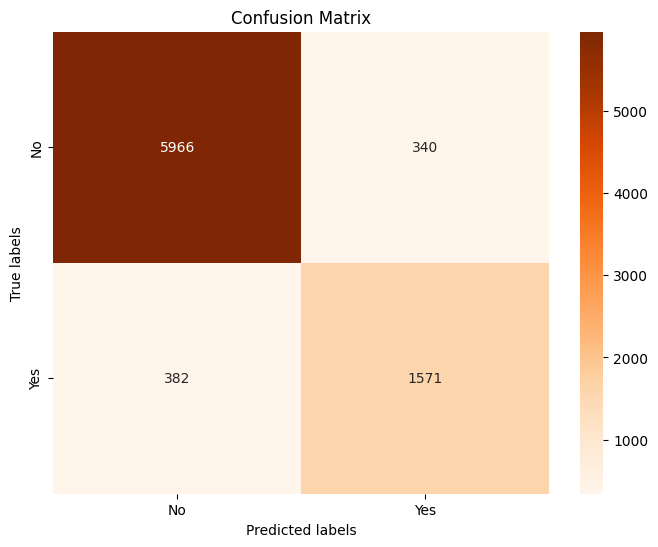

In [92]:
rf_feature_select_n200_predictions = rf_feature_select_n200.predict(X_test)

conf_matrix = confusion_matrix(y_test, rf_feature_select_n200_predictions)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [93]:
print_scores(y_test, rf_feature_select_n200_predictions);

Accuracy: 0.9125802155224604
Precision: 0.8220826792255364
Recall: 0.8044034818228366
F1 Score: 0.8131469979296067


In [94]:
rf_feat_select_n200_scores = cross_val_scores(rf_feature_select_n200, X, y);

CV Scores Fold 1
Accuracy: 0.9106429349800218
Precision: 0.7845617095508068
Recall: 0.8805677924620656
F1 Score: 0.8297970479704797

CV Scores Fold 2
Accuracy: 0.91306453565807
Precision: 0.8244626407369499
Recall: 0.8111782477341389
F1 Score: 0.817766497461929

CV Scores Fold 3
Accuracy: 0.9118537353190459
Precision: 0.8227848101265823
Recall: 0.8112830753869196
F1 Score: 0.8169934640522876

CV Scores Fold 4
Accuracy: 0.9102796948783146
Precision: 0.821304131408661
Recall: 0.812007874015748
F1 Score: 0.8166295471417966

CV Scores Fold 5
Accuracy: 0.916939096742947
Precision: 0.8258483033932136
Recall: 0.8308232931726908
F1 Score: 0.8283283283283284



In [95]:
df_rf_feat_select_n200_scores = pd.DataFrame(rf_feat_select_n200_scores)

In [96]:
df_rf_feat_select_n200_scores.mean()

accuracy     0.912556
precision    0.815792
recall       0.829172
f1           0.821903
dtype: float64

Increasing the number of decisions trees in the forest was not able to improve predictive performance

## Summary

In [97]:
scores = [
    df_lr_scores.mean(),
    df_log_reg_scores.mean(),
    df_rf_scores.mean(),
    df_el_net_feat_select_scores.mean(),
    df_log_reg_feat_select_scores.mean(),
    df_rf_feat_select_scores.mean(),
    df_rf_feat_select_n200_scores.mean()
]

df_scores = pd.DataFrame(scores, index=['Linear Regression', 
                                        'Logistic Regression', 
                                        'Random Forest', 
                                        'Elastic Net Feature Select', 
                                        'Logistic Regression Feature Select', 
                                        'Random Forest Feature Select', 
                                        'Random Forest Feature Select n=200'])
df_scores

,accuracy,precision,recall,f1
Linear Regression,0.920305,0.844089,0.825010,0.834422
Logistic Regression,0.923889,0.850845,0.833464,0.842054
Random Forest,0.922024,0.834785,0.847651,0.841135
Elastic Net Feature Select,0.920208,0.851124,0.814783,0.832548
Logistic Regression Feature Select,0.917351,0.849642,0.802685,0.825459
Random Forest Feature Select,0.910619,0.803392,0.841677,0.820891
Random Forest Feature Select n=200,0.912556,0.815792,0.829172,0.821903


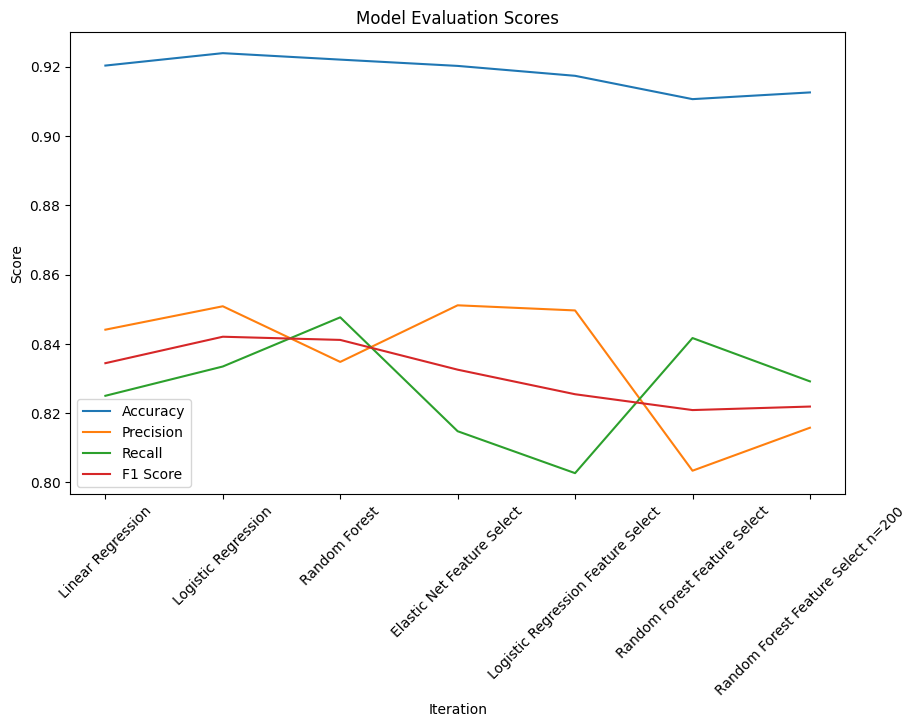

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(df_scores.index, df_scores['accuracy'], label='Accuracy')
plt.plot(df_scores.index, df_scores['precision'], label='Precision')
plt.plot(df_scores.index, df_scores['recall'], label='Recall')
plt.plot(df_scores.index, df_scores['f1'], label='F1 Score')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Model Evaluation Scores')
plt.legend()

plt.xticks(rotation=45)

plt.show()


With repect to the problem statement **"...using the data collected by CDC to build a data analytics solution for death risk prediction."**, and with careful consideration for consequences of relying on that solution, I have concluded:
- `recall` is the most appropriate measure on which to evaluate a model considering the consequences of false negatives
- A feature selected Random Forest Classifier with n=100 estimators is the best choice from what we have investigated here

It's important to note that this model has the _worst_ `accuracy` and `precision`, but this trade-off is intuitive and, in my opinion, desirable

When people's lives are at stake it is of principle concern to identify the greatest number of positive observations (observations that are of a high death risk) as possible